# Build a Retrieval Augmented Generation (RAG) App: Part 2

In many Q&A applications we want to allow the user to have a back-and-forth conversation, meaning the application needs some sort of "memory" of past questions and answers, and some logic for incorporating those into its current thinking.

This is the second part of a multi-part tutorial:

- [Part 1](/docs/tutorials/rag) introduces RAG and walks through a minimal implementation.
- [Part 2](/docs/tutorials/qa_chat_history) (this guide) extends the implementation to accommodate conversation-style interactions and multi-step retrieval processes.

Here we focus on **adding logic for incorporating historical messages.** This involves the management of a [chat history](/docs/concepts/chat_history).

We will cover two approaches:

1. [Chains](/docs/tutorials/qa_chat_history/#chains), in which we execute at most one retrieval step;
2. [Agents](/docs/tutorials/qa_chat_history/#agents), in which we give an LLM discretion to execute multiple retrieval steps.

:::note

The methods presented here leverage [tool-calling](/docs/concepts/tool_calling/) capabilities in modern [chat models](/docs/concepts/chat_models). See [this page](/docs/integrations/chat/) for a table of models supporting tool calling features.

:::

For the external knowledge source, we will use the same [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng from the [Part 1](/docs/tutorials/rag) of the RAG tutorial.

In [1]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

## Setup

### Components

We will need to select three components from LangChain's suite of integrations.

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [ ]:
# # | output: false
# # | echo: false

# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o-mini")

In [2]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [ ]:
# # | output: false
# # | echo: false

# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings()

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [4]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

### Dependencies

In addition, we'll use the following packages:

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

### LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with [LangSmith](https://smith.langchain.com).

Note that LangSmith is not needed, but it is helpful. If you do want to use LangSmith, after you sign up at the link above, make sure to set your environment variables to start logging traces:

```python
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
```

## Chains {#chains}

Let's first revisit the vector store we built in [Part 1](/docs/tutorials/rag), which indexes an [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng.

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In the [Part 1](/docs/tutorials/rag) of the RAG tutorial, we represented the user input, retrieved context, and generated answer as separate keys in the state. Conversational experiences can be naturally represented using a sequence of [messages](/docs/concepts/messages/). In addition to messages from the user and assistant, retrieved documents and other artifacts can be incorporated into a message sequence via [tool messages](/docs/concepts/messages/#toolmessage). This motivates us to represent the state of our RAG application using a sequence of messages. Specifically, we will have

1. User input as a `HumanMessage`;
2. Vector store query as an `AIMessage` with tool calls;
3. Retrieved documents as a `ToolMessage`;
4. Final response as a `AIMessage`.

This model for state is so versatile that LangGraph offers a built-in version for convenience:

In [7]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

Leveraging [tool-calling](/docs/concepts/tool_calling/) to interact with a retrieval step has another benefit, which is that the query for the retrieval is generated by our model. This is especially important in a conversational setting, where user queries may require contextualization based on the chat history. For instance, consider the following exchange:

> Human: "What is Task Decomposition?"
>
> AI: "Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable for an agent or model."
>
> Human: "What are common ways of doing it?"

In this scenario, a model could generate a query such as `"common approaches to task decomposition"`. Tool-calling facilitates this naturally. As in the [query analysis](/docs/tutorials/rag#query-analysis) section of the RAG tutorial, this allows a model to rewrite user queries into more effective search queries. It also provides support for direct responses that do not involve a retrieval step (e.g., in response to a generic greeting from the user).

Let's turn our retrieval step into a [tool](/docs/concepts/tools):

In [8]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

See [this guide](/docs/how_to/custom_tools/) for more detail on creating tools.

Our graph will consist of three nodes:

1. A node that fields the user input, either generating a query for the retriever or responding directly;
2. A node for the retriever tool that executes the retrieval step;
3. A node that generates the final response using the retrieved context.

We build them below. Note that we leverage another pre-built LangGraph component, [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode), that executes the tool and adds the result as a `ToolMessage` to the state.

In [9]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the steps into a sequence. We also allow the first `query_or_respond` step to "short-circuit" and respond directly to the user if it does not generate a tool call. This allows our application to support conversational experiences-- e.g., responding to generic greetings that may not require a retrieval step

In [10]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

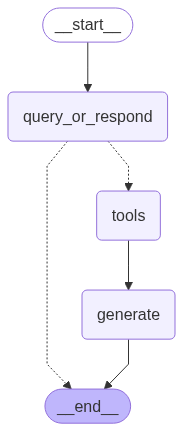

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test our application.

Note that it responds appropriately to messages that do not require an additional retrieval step:

In [12]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


And when executing a search, we can stream the steps to observe the query generation, retrieval, and answer generation:

In [13]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_xwvdqNWLYiCAhKtP5dOqGdEO)
 Call ID: call_xwvdqNWLYiCAhKtP5dOqGdEO
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to des

Check out the LangSmith trace [here](https://smith.langchain.com/public/70110399-01d3-4b4b-9139-cbcd4edf9d6d/r).

### Stateful management of chat history

:::note

This section of the tutorial previously used the [RunnableWithMessageHistory](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html) abstraction. You can access that version of the documentation in the [v0.2 docs](https://python.langchain.com/v0.2/docs/tutorials/chatbot/).

As of the v0.3 release of LangChain, we recommend that LangChain users take advantage of [LangGraph persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) to incorporate `memory` into new LangChain applications.

If your code is already relying on `RunnableWithMessageHistory` or `BaseChatMessageHistory`, you do **not** need to make any changes. We do not plan on deprecating this functionality in the near future as it works for simple chat applications and any code that uses `RunnableWithMessageHistory` will continue to work as expected.

Please see [How to migrate to LangGraph Memory](/docs/versions/migrating_memory/) for more details.
:::

In production, the Q&A application will usually persist the chat history into a database, and be able to read and update it appropriately.

[LangGraph](https://langchain-ai.github.io/langgraph/) implements a built-in [persistence layer](https://langchain-ai.github.io/langgraph/concepts/persistence/), making it ideal for chat applications that support multiple conversational turns.

To manage multiple conversational turns and threads, all we have to do is specify a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/) when compiling our application. Because the nodes in our graph are appending messages to the state, we will retain a consistent chat history across invocations.

LangGraph comes with a simple in-memory checkpointer, which we use below. See its [documentation](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more detail, including how to use different persistence backends (e.g., SQLite or Postgres).

For a detailed walkthrough of how to manage message history, head to the [How to add message history (memory)](/docs/how_to/message_history) guide.

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

We can now invoke similar to before:

In [15]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_D8WXKvRnjyGBcthHY7Fj4F6x)
 Call ID: call_D8WXKvRnjyGBcthHY7Fj4F6x
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to des

In [16]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_F3BOJVM31LnE9w2OLgUQ2T9B)
 Call ID: call_F3BOJVM31LnE9w2OLgUQ2T9B
  Args:
    query: common ways of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as

Note that the query generated by the model in the second question incorporates the conversational context.

The [LangSmith](https://smith.langchain.com/public/28e6179f-fc56-45e1-9028-447d76352c14/r) trace is particularly informative here, as we can see exactly what messages are visible to our chat model at each step.

## Agents {#agents}

[Agents](/docs/concepts/agents) leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allows you to offload additional discretion over the retrieval process. Although their behavior is less predictable than the above "chain", they are able to execute multiple retrieval steps in service of a query, or iterate on a single search.

Below we assemble a minimal RAG agent. Using LangGraph's [pre-built ReAct agent constructor](https://langchain-ai.github.io/langgraph/how-tos/#langgraph.prebuilt.chat_agent_executor.create_react_agent), we can do this in one line.

:::tip

Check out LangGraph's [Agentic RAG](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/) tutorial for more advanced formulations.

:::

In [17]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

Let's inspect the graph:

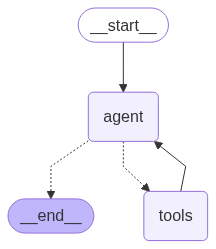

In [18]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

The key difference from our earlier implementation is that instead of a final generation step that ends the run, here the tool invocation loops back to the original LLM call. The model can then either answer the question using the retrieved context, or generate another tool call to obtain more information.

Let's test this out. We construct a question that would typically require an iterative sequence of retrieval steps to answer:

In [19]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_0VIYNzYl9nOHAYv8tl4ECvhK)
 Call ID: call_0VIYNzYl9nOHAYv8tl4ECvhK
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon pla

Note that the agent:

1. Generates a query to search for a standard method for task decomposition;
2. Receiving the answer, generates a second query to search for common extensions of it;
3. Having received all necessary context, answers the question.

We can see the full sequence of steps, along with latency and other metadata, in the [LangSmith trace](https://smith.langchain.com/public/48cbd35e-9ac1-49ab-8c09-500d54c06b81/r).

## Next steps

We've covered the steps to build a basic conversational Q&A application:

- We used chains to build a predictable application that generates at most one query per user input;
- We used agents to build an application that can iterate on a sequence of queries.

To explore different types of retrievers and retrieval strategies, visit the [retrievers](/docs/how_to/#retrievers) section of the how-to guides.

For a detailed walkthrough of LangChain's conversation memory abstractions, visit the [How to add message history (memory)](/docs/how_to/message_history) guide.

To learn more about agents, check out the [conceptual guide](/docs/concepts/agents) and LangGraph [agent architectures](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/) page.